In [1]:
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, denormalize_data, rmse, bias, rel_error
from bahdanau_att import EncoderLSTM, BahdanauDecoder


import matplotlib.pyplot as plt
%matplotlib inline

# DATA IMPORTATION AND VISUALIZATION

In [2]:
datadir = 'data'
dataset = 'tem_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Average Traffic Dataset', figsize=(14, 4), dpi=85)
plt.plot(data.squeeze().numpy())
plt.title('Average Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Traffic intensity')

Text(0, 0.5, 'Traffic intensity')

# TRAINING AND TEST ERROR METRICS
 - Additional parameters via --parameter_name value
 - For simplicity, 60%-20%-20% validation scheme (training-validation-test)

In [3]:
 run training.py

 45%|████▌     | 90/200 [17:55<21:28, 11.71s/it, lr=0.0001, train_mse=0.000102, train_rmse=0.0101, val_mse=0.00674, val_rmse=0.0821]



 *  Test MSE:  7109.08154296875 
 *  Test RMSE:  84.31536955365107 
 *  Test Bias:  -1.9732249975204468 
 *  Test Rel-Err (%):  9.342940151691437



<Figure size 432x288 with 0 Axes>

# RESULTS
 - Example: average prediction from 00:00 to 23:00
 - Learning curve
 - Error distribution: temporal

In [4]:
outputdir  = opt.outputdir
with open(os.path.join(outputdir, 'logs.json'), 'r') as f:
    logs = json.load(f)
    
with open(os.path.join(outputdir, 'config.json'), 'r') as f:
    config = json.load(f)

opt = DotDict(config)

In [5]:
encoder = EncoderLSTM(opt.in_dim, opt.n_hidden)
encoder.to(device)
encoder.load_state_dict(torch.load(os.path.join(outputdir,"encoder_model.pth")))
decoder = BahdanauDecoder(opt.n_hidden, opt.out_dim)
decoder.to(device)
decoder.load_state_dict(torch.load(os.path.join(outputdir,"decoder_model.pth")))

<All keys matched successfully>

In [6]:
_, _, _, _, X_test, Y_test, min_value, max_value = data_transform(opt)

test_dataset = []
for i in range(len(X_test)):
   test_dataset.append([X_test[i], Y_test[i]]) 
    
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = len(X_test),
                                           shuffle = False)

In [7]:
def evaluate(encoder, decoder, batch, device = device):
     output = torch.Tensor().to(device)
     
     h = encoder.init_hidden(batch.size(0))
            
     encoder_output, h = encoder(batch,h)
     decoder_hidden = h
     decoder_input = torch.zeros(batch.size(0), 1, device = device)
            
     for k in range(opt.n_out):
         decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_output)
         decoder_input = decoder_output
         output = torch.cat((output, decoder_output),1)

     return output

In [8]:
encoder.eval()
decoder.eval()
with torch.no_grad():    
    for x,y in test_loader:
        x = x.view(-1,opt.n_inp,opt.in_dim).to(device)
        y = y.to(device)
     
        y_pred = evaluate(encoder, decoder, x)
        
        y_pred_dnorm = denormalize_data(y_pred, min_value, max_value).cpu()
        y_dnorm = denormalize_data(y, min_value, max_value).cpu()

y_tstep = y_dnorm[1::24]
y_pred_tstep = y_pred_dnorm[1::24]

# Example

Text(0.5, 1.0, 'Average prediction')

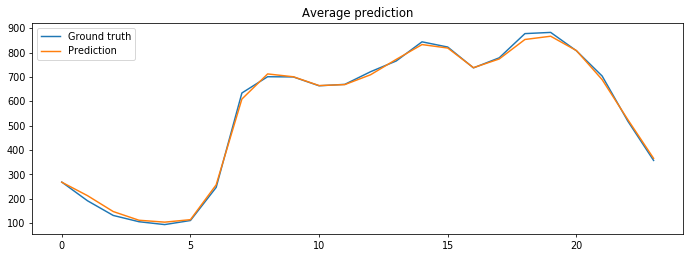

In [9]:
real = y_tstep.mean(0)
prediction = y_pred_tstep.mean(0)

plt.figure('Results', figsize=(12, 4), dpi=70)

plt.plot(real, label = 'Ground truth')
plt.plot(prediction, label = 'Prediction')
plt.legend()
plt.title('Average prediction')

# Learning curve

In [10]:
plt.figure('Error', figsize=(12, 4), dpi=70)
plt.plot(np.sqrt(logs['train.mse']), label = 'Train')
plt.plot(np.sqrt(logs['val.mse']), label = 'Validation')
plt.legend()

# Temporal RMSE distribution: hour

Text(0.5, 0, 'Hour of the day')

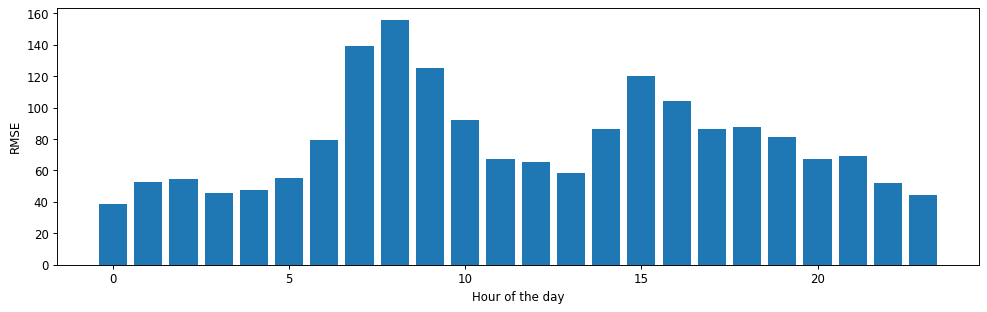

In [11]:
plt.figure('RMSE dist hour', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_tstep,y_tstep, reduce = False))
plt.ylabel('RMSE')
plt.xlabel('Hour of the day')

# Temporal RMSE distribution: timestep

Text(0.5, 0, 'Timestep')

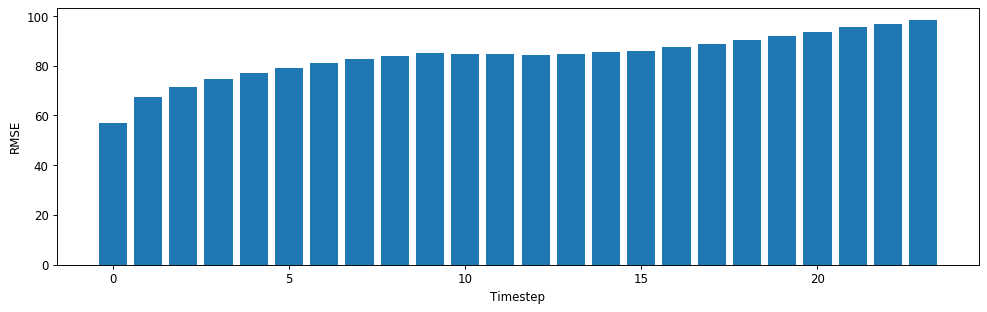

In [12]:
plt.figure('RMSE dist timestep', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_dnorm, y_dnorm, reduce = False))
plt.ylabel('RMSE')
plt.xlabel('Timestep')